# Assignment 3 Math Foundations Machine Learning
## David Alvear 187594

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, random_split, DataLoader

## 1. Binary logistic regression with SGD.

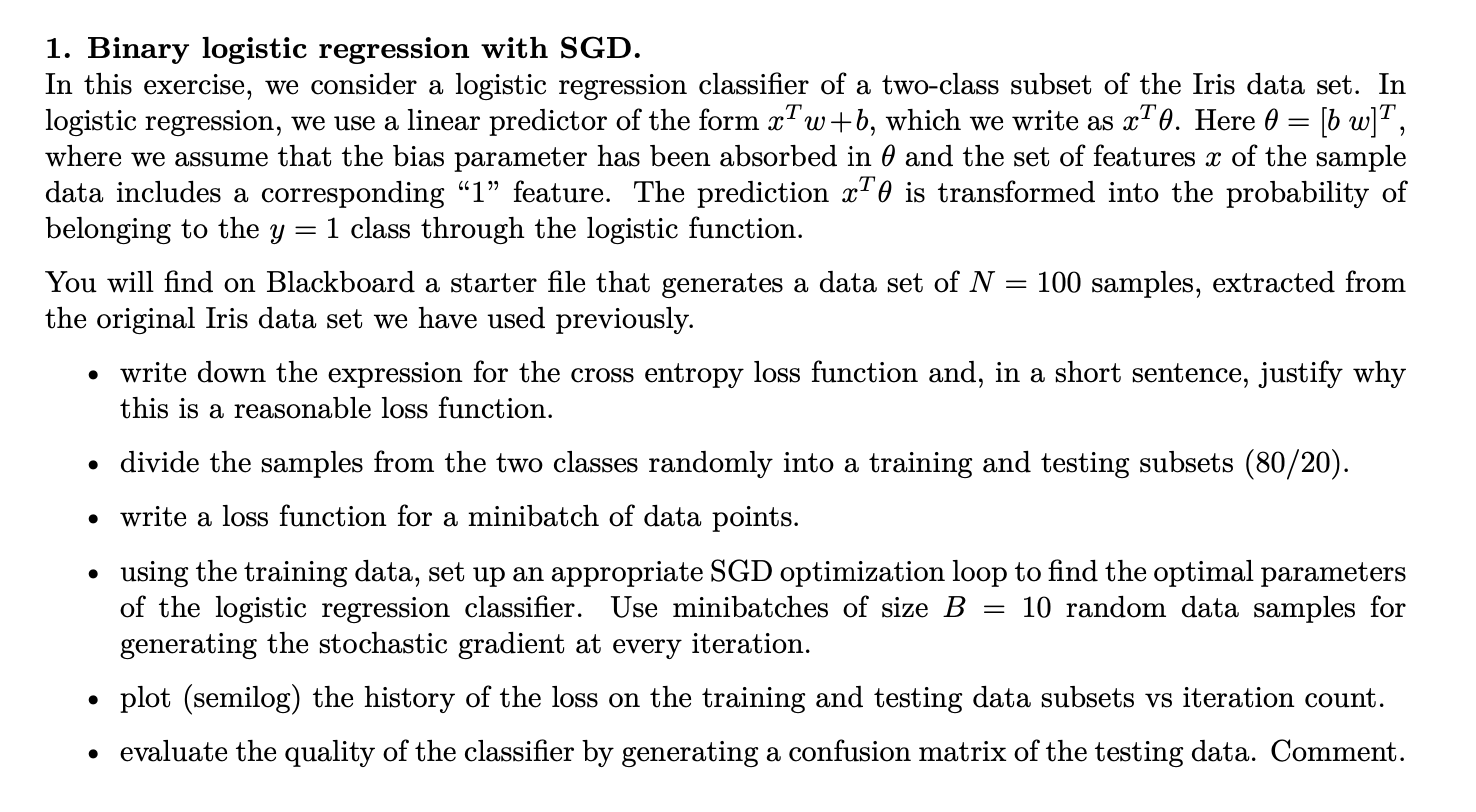

In [2]:
df = pd.read_csv('../data/iris.csv')

# extract only two classes 'Iris-setosa' and 'Iris-versicolor'. Drop 'Iris-virginica'
df = df[df['species'] != 'Iris-virginica']

# make the labels 1 and 0
df['species'].replace(["Iris-setosa","Iris-versicolor"], [1,0], inplace=True)

# generate X and y tensors, adding the ``1'' feature for the bias
N, D = df.shape
X = torch.tensor(df.iloc[:, 0:D-1].values, dtype=torch.float32)
X = torch.cat((torch.ones((N,1)), X), dim=1)
y = torch.tensor(df.iloc[:, D-1].values, dtype=torch.float32)

In [3]:
##########################################
####### Create Dataset for IRIS ##########
##########################################
class IrisDataset(Dataset):
    def __init__(self, X:torch.tensor, Y:torch.tensor):
        self.X = X
        self.Y = Y
        self.feature_size = self.X.size(1)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

##########################################
###### Split and create Dataset ##########
##########################################
def divide_dataset(dataset, test_prop=0.2):
    train_size = int(len(dataset) * (1 - test_prop))
    test_size = int(len(dataset) * test_prop)
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    return train_dataset, test_dataset
    
##########################################
############## Plot semilog ##############
##########################################
def plot_loss(train_loss, test_loss):
    plt.figure(figsize=(12, 6))
    plt.semilogy(train_loss, label='Training Loss')
    plt.semilogy(test_loss, label='Testing Loss')
    ymin, ymax = plt.ylim()  # Get current y-axis limits
    yticks = np.linspace(ymin, ymax, num=10)  # Create 10 equally spaced ticks
    plt.yticks(yticks)  # Set custom y-ticks
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Convergence')
    plt.legend()
    plt.grid(True)
    plt.show()

def visualize_confusion_matrix(test_labels, test_predicted_labels, labels=[1,0]):
    print("\nCONFUSSION MATRIX\n")
    conf_matrix = confusion_matrix(test_labels, test_predicted_labels)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def visualize_classification_report(test_labels, test_predicted_labels, labels=[1,0]):
    # Generate the test classification report
    print("\nCLASSIFICATION REPORT\n")
    report = classification_report(test_labels, test_predicted_labels, target_names=labels)
    print(report)

In [4]:
##########################################
###### Logistic Regression Model #########
##########################################
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

##########################################
##### Logistic Regression Training #######
##########################################
class BinaryLogisticRegression:
    def __init__(self, model:torch.nn.Module, train_dataset:Dataset, test_dataset:Dataset, criterion='manual'):
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.criterion = criterion if criterion == 'manual' else torch.nn.BCELoss()
        self.model = model

    def loss(self, pred_tensor, labels_tensor):
        if self.criterion == 'manual':
            loss = -torch.mean(labels_tensor.squeeze() * torch.log(pred_tensor.squeeze()) + (1 - labels_tensor.squeeze()) * torch.log(1 - pred_tensor.squeeze()))
        else:
            loss = self.criterion(pred_tensor.squeeze(), labels_tensor.squeeze())
        return loss

    def test_model(self):
        # get the data
        test_data, labels = self.test_dataset[:]
        # predict 
        with torch.no_grad():
            pred_labels = self.model(test_data)
        test_loss = self.loss(pred_labels, labels)
        return test_loss.item()

    def SGD(self, learning_rate=0.001, batch_size=10, num_epochs=100):
        opt = torch.optim.SGD(self.model.parameters(), lr=learning_rate)
        data_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True) # randomize and get the batches

        self.train_loss = []
        self.test_loss = []
        for epoch in range(num_epochs):
            total_loss = 0
            for data_batch, label_batch in data_loader:

                # Reset gradients
                self.model.zero_grad()
            
                # Forward pass
                prob_predicted = self.model(data_batch)
        
                # calculate loss
                loss = self.loss(prob_predicted, label_batch) # compute the loss for the batch
                total_loss += loss.item()
        
                # Backward pass
                loss.backward()
    
                # step SGD opt
                opt.step()

            # test the model 
            loss_test_epoch = self.test_model()
            self.train_loss.append(total_loss / len(data_loader))
            self.test_loss.append(loss_test_epoch)
            # print epoch
            print(f"Epoch: {epoch}, Training Loss Avg: {total_loss / len(data_loader):.4f}, Test Loss: {loss_test_epoch:.4f}")
    

In [5]:
# Divide Data into Training and Testing
iris_dataset = IrisDataset(X, y)
train_dataset, test_dataset = divide_dataset(iris_dataset, test_prop=0.2) # 0.8 of training size rate

In [6]:
# Create the model
feature_size = iris_dataset.feature_size
model = LogisticRegression(feature_size)

# Create the trainer
BLR_trainer = BinaryLogisticRegression(model, train_dataset, test_dataset, criterion='manual') # BCEloss

In [7]:
# Train the model
BLR_trainer.SGD(num_epochs=1000)

Epoch: 0, Training Loss Avg: 0.9203, Test Loss: 1.0237
Epoch: 1, Training Loss Avg: 0.9125, Test Loss: 1.0118
Epoch: 2, Training Loss Avg: 0.9041, Test Loss: 1.0006
Epoch: 3, Training Loss Avg: 0.8972, Test Loss: 0.9900
Epoch: 4, Training Loss Avg: 0.8906, Test Loss: 0.9804
Epoch: 5, Training Loss Avg: 0.8843, Test Loss: 0.9711
Epoch: 6, Training Loss Avg: 0.8778, Test Loss: 0.9623
Epoch: 7, Training Loss Avg: 0.8719, Test Loss: 0.9538
Epoch: 8, Training Loss Avg: 0.8668, Test Loss: 0.9458
Epoch: 9, Training Loss Avg: 0.8603, Test Loss: 0.9382
Epoch: 10, Training Loss Avg: 0.8554, Test Loss: 0.9311
Epoch: 11, Training Loss Avg: 0.8497, Test Loss: 0.9241
Epoch: 12, Training Loss Avg: 0.8451, Test Loss: 0.9174
Epoch: 13, Training Loss Avg: 0.8402, Test Loss: 0.9108
Epoch: 14, Training Loss Avg: 0.8343, Test Loss: 0.9045
Epoch: 15, Training Loss Avg: 0.8297, Test Loss: 0.8985
Epoch: 16, Training Loss Avg: 0.8252, Test Loss: 0.8926
Epoch: 17, Training Loss Avg: 0.8204, Test Loss: 0.8867
Ep

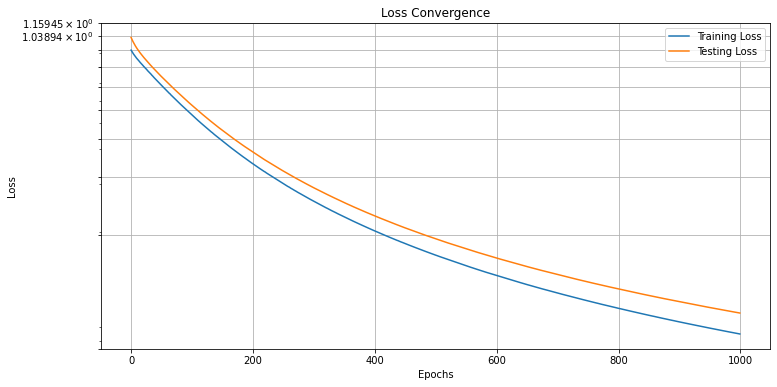

In [8]:
# Plot the semilog of the training and test loss
train_loss = BLR_trainer.train_loss
test_loss = BLR_trainer.test_loss
plot_loss(train_loss, test_loss)


CONFUSSION MATRIX



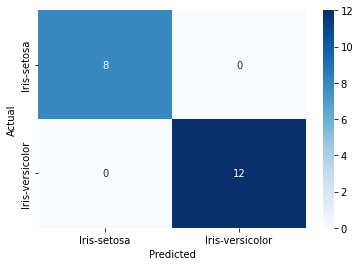


CLASSIFICATION REPORT

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         8
Iris-versicolor       1.00      1.00      1.00        12

       accuracy                           1.00        20
      macro avg       1.00      1.00      1.00        20
   weighted avg       1.00      1.00      1.00        20



In [9]:
# Visualize confusion matrix to obtain more information
test_data, test_labels = test_dataset[:]
prob_predicted = model(test_data).squeeze()
test_labels_predicted = (prob_predicted > 0.5).float()
visualize_confusion_matrix(test_labels, test_labels_predicted, labels=["Iris-setosa","Iris-versicolor"])
visualize_classification_report(test_labels, test_labels_predicted, labels=["Iris-setosa","Iris-versicolor"])

### Comments

- The model was trained for 1000 epochs using a batch_size of 10 with a learning rate 0.001. The Dataset and Dataloader of PyTorch was used for spliting the data in test and training as well as handling the batches of lenght 10 for the training.
- The avg of the training loss was computed after each epoch as well as the test loss.
- Looking at the semilog for the train and test loss we can see how the prediction is improving on each iteration. We can relate this behaviour with the final confusion matrix result and the classification report. Near to the 1000 iteration the loss is below 0.08 and the results in the classification report conclude that after the mentioned iterations the model is capable of predict the two types of labels using unseen data.

## 2. Multiclass logistic regression.

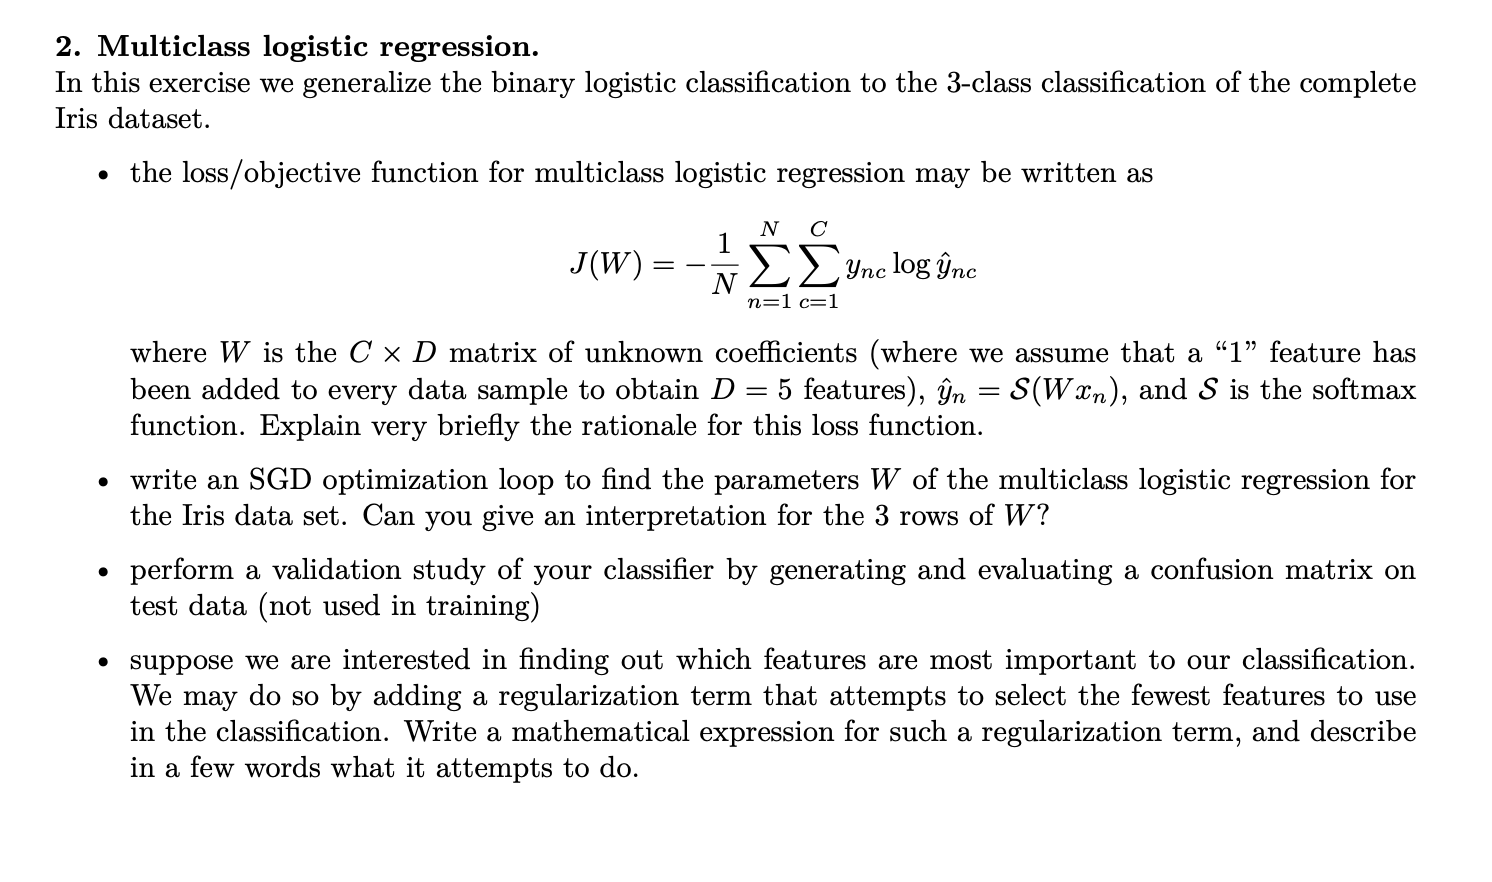

In [10]:
# prepare the data for multi-class
df = pd.read_csv('../data/iris.csv')

# make the labels 1 and 0
df['species'].replace(["Iris-setosa","Iris-versicolor","Iris-virginica"], [0,1,2], inplace=True)
y_one_hot = pd.get_dummies(df['species']).values

# generate X and y tensors, adding the ``1'' feature for the bias
N, D = df.shape
X = torch.tensor(df.iloc[:, 0:D-1].values, dtype=torch.float32)
X = torch.cat((torch.ones((N,1)), X), dim=1)
y = torch.tensor(y_one_hot, dtype=torch.float32)

In [11]:
# Divide Data into Training and Testing
mc_iris_dataset = IrisDataset(X, y)
train_dataset, test_dataset = divide_dataset(mc_iris_dataset, test_prop=0.2) # 0.8 of training size rate

In [12]:
##########################################
## Multiclass Logistic Regression Model ##
##########################################
class MulticlassLogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MulticlassLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.linear(x)
        
##########################################
##### Logistic Regression Training #######
##########################################
class MulticlassLogisticRegressionTrainer(BinaryLogisticRegression):
    def __init__(self, model:torch.nn.Module, train_dataset:Dataset, test_dataset:Dataset, criterion='manual', regularizer='l1', lambda_reg=0.001):
        super(MulticlassLogisticRegressionTrainer, self).__init__(model, train_dataset, test_dataset, criterion='manual')
        self.criterion = criterion if criterion == 'manual' else torch.nn.CrossEntropyLoss()
        self.regularizer = regularizer
        self.lambda_reg = lambda_reg
        
    # Redefine the loss for the multiclass application
    def loss(self, pred_tensor, labels_tensor):
        if self.criterion == 'manual':
            loss = -torch.mean(torch.sum(labels_tensor * torch.log(torch.softmax(pred_tensor, dim=1)), dim=1))
        else:
            loss = self.criterion(pred_tensor, labels_tensor)

        if self.regularizer == 'l1':
            loss += self.lambda_reg * sum(torch.norm(p, 1) for p in model.parameters())

        return loss
        

In [13]:
# Create the model
feature_size = iris_dataset.feature_size
# feature_size = (3, iris_dataset.feature_size)
mc_model = MulticlassLogisticRegression(feature_size, 3)
print(mc_model.linear.weight)

Parameter containing:
tensor([[ 0.1820,  0.2514,  0.3405,  0.1840, -0.3172],
        [-0.3069,  0.1848,  0.0684,  0.4437,  0.1427],
        [-0.2393,  0.2485,  0.0347, -0.1230, -0.1107]], requires_grad=True)


### Train without regularization

**The matrix W of size CxD is defined in the linear layer of the model**

In [14]:
# Create the trainer
MLR_trainer = MulticlassLogisticRegressionTrainer(mc_model, train_dataset, test_dataset, criterion='manual', regularizer=None) # crossentropyloss
# Train the model
MLR_trainer.SGD(num_epochs=2000)

Epoch: 0, Training Loss Avg: 1.4198, Test Loss: 1.7310
Epoch: 1, Training Loss Avg: 1.3201, Test Loss: 1.5906
Epoch: 2, Training Loss Avg: 1.2371, Test Loss: 1.4695
Epoch: 3, Training Loss Avg: 1.1689, Test Loss: 1.3695
Epoch: 4, Training Loss Avg: 1.1150, Test Loss: 1.2874
Epoch: 5, Training Loss Avg: 1.0735, Test Loss: 1.2216
Epoch: 6, Training Loss Avg: 1.0418, Test Loss: 1.1691
Epoch: 7, Training Loss Avg: 1.0173, Test Loss: 1.1284
Epoch: 8, Training Loss Avg: 1.0008, Test Loss: 1.0976
Epoch: 9, Training Loss Avg: 0.9857, Test Loss: 1.0722
Epoch: 10, Training Loss Avg: 0.9747, Test Loss: 1.0523
Epoch: 11, Training Loss Avg: 0.9644, Test Loss: 1.0351
Epoch: 12, Training Loss Avg: 0.9572, Test Loss: 1.0203
Epoch: 13, Training Loss Avg: 0.9500, Test Loss: 1.0086
Epoch: 14, Training Loss Avg: 0.9434, Test Loss: 0.9969
Epoch: 15, Training Loss Avg: 0.9356, Test Loss: 0.9883
Epoch: 16, Training Loss Avg: 0.9303, Test Loss: 0.9801
Epoch: 17, Training Loss Avg: 0.9253, Test Loss: 0.9721
Ep

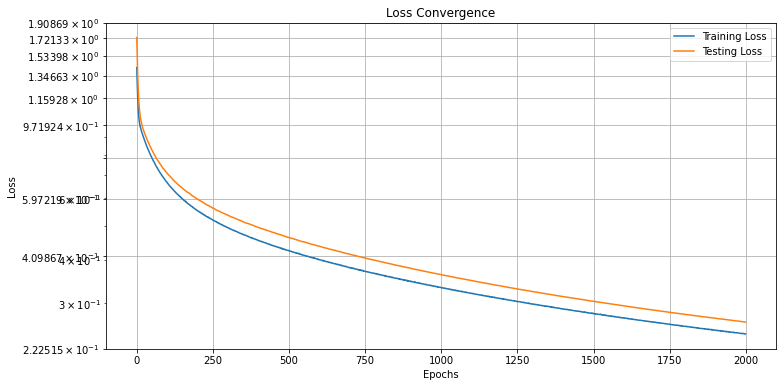

In [15]:
# Plot the semilog of the training and test loss
train_loss = MLR_trainer.train_loss
test_loss = MLR_trainer.test_loss
plot_loss(train_loss, test_loss)


CONFUSSION MATRIX



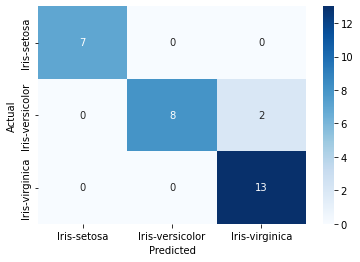


CLASSIFICATION REPORT

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         7
Iris-versicolor       1.00      0.80      0.89        10
 Iris-virginica       0.87      1.00      0.93        13

       accuracy                           0.93        30
      macro avg       0.96      0.93      0.94        30
   weighted avg       0.94      0.93      0.93        30



In [16]:
# Visualize confusion matrix to obtain more information
test_data, test_labels = test_dataset[:]
test_labels_indices = torch.argmax(test_labels, dim=1)
test_logits = mc_model(test_data).squeeze()
test_labels_predicted = torch.softmax(test_logits, dim=1).squeeze().detach()
test_labels_predicted_indices = torch.argmax(test_labels_predicted, dim=1)

visualize_confusion_matrix(test_labels_indices, test_labels_predicted_indices, labels=["Iris-setosa","Iris-versicolor","Iris-virginica"])
visualize_classification_report(test_labels_indices, test_labels_predicted_indices, labels=["Iris-setosa","Iris-versicolor","Iris-virginica"])

### Train with regularization

- Added Regularization L1 or LASSO.
- The objective of this regularization is to perform feature selection, and also encourage sparse solutions. This term reduce cero values in w. Features that doesn't matter are eliminated.

In [17]:
# create a new model
model_reg = MulticlassLogisticRegression(feature_size, 3)
# Create the trainer
MLR_trainer_reg = MulticlassLogisticRegressionTrainer(model_reg, train_dataset, test_dataset, criterion='manual', regularizer='l1') # crossentropyloss
# Train the model
MLR_trainer_reg.SGD(num_epochs=1000)

Epoch: 0, Training Loss Avg: 1.0671, Test Loss: 1.0074
Epoch: 1, Training Loss Avg: 1.0422, Test Loss: 0.9872
Epoch: 2, Training Loss Avg: 1.0219, Test Loss: 0.9718
Epoch: 3, Training Loss Avg: 1.0056, Test Loss: 0.9599
Epoch: 4, Training Loss Avg: 0.9923, Test Loss: 0.9498
Epoch: 5, Training Loss Avg: 0.9823, Test Loss: 0.9419
Epoch: 6, Training Loss Avg: 0.9725, Test Loss: 0.9345
Epoch: 7, Training Loss Avg: 0.9650, Test Loss: 0.9281
Epoch: 8, Training Loss Avg: 0.9577, Test Loss: 0.9221
Epoch: 9, Training Loss Avg: 0.9509, Test Loss: 0.9159
Epoch: 10, Training Loss Avg: 0.9442, Test Loss: 0.9103
Epoch: 11, Training Loss Avg: 0.9380, Test Loss: 0.9045
Epoch: 12, Training Loss Avg: 0.9336, Test Loss: 0.8999
Epoch: 13, Training Loss Avg: 0.9267, Test Loss: 0.8943
Epoch: 14, Training Loss Avg: 0.9199, Test Loss: 0.8892
Epoch: 15, Training Loss Avg: 0.9140, Test Loss: 0.8844
Epoch: 16, Training Loss Avg: 0.9084, Test Loss: 0.8796
Epoch: 17, Training Loss Avg: 0.9023, Test Loss: 0.8748
Ep

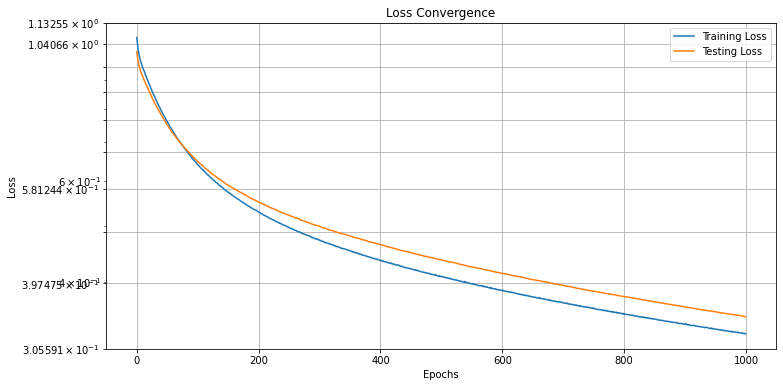

In [18]:
# Plot the semilog of the training and test loss 
plot_loss(MLR_trainer_reg.train_loss, MLR_trainer_reg.test_loss)


CONFUSSION MATRIX



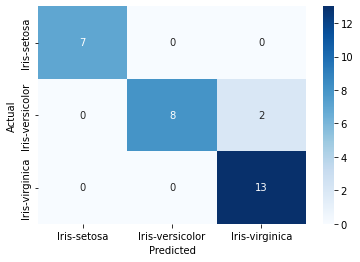


CLASSIFICATION REPORT

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         7
Iris-versicolor       1.00      0.80      0.89        10
 Iris-virginica       0.87      1.00      0.93        13

       accuracy                           0.93        30
      macro avg       0.96      0.93      0.94        30
   weighted avg       0.94      0.93      0.93        30



In [19]:
# Visualize confusion matrix to obtain more information
test_data, test_labels = test_dataset[:]
test_labels_indices = torch.argmax(test_labels, dim=1)
test_logits = model_reg(test_data).squeeze()
test_labels_predicted = torch.softmax(test_logits, dim=1).squeeze().detach()
test_labels_predicted_indices = torch.argmax(test_labels_predicted, dim=1)

visualize_confusion_matrix(test_labels_indices, test_labels_predicted_indices, labels=["Iris-setosa","Iris-versicolor","Iris-virginica"])
visualize_classification_report(test_labels_indices, test_labels_predicted_indices, labels=["Iris-setosa","Iris-versicolor","Iris-virginica"])

## 3. Hypergradient optimization. 

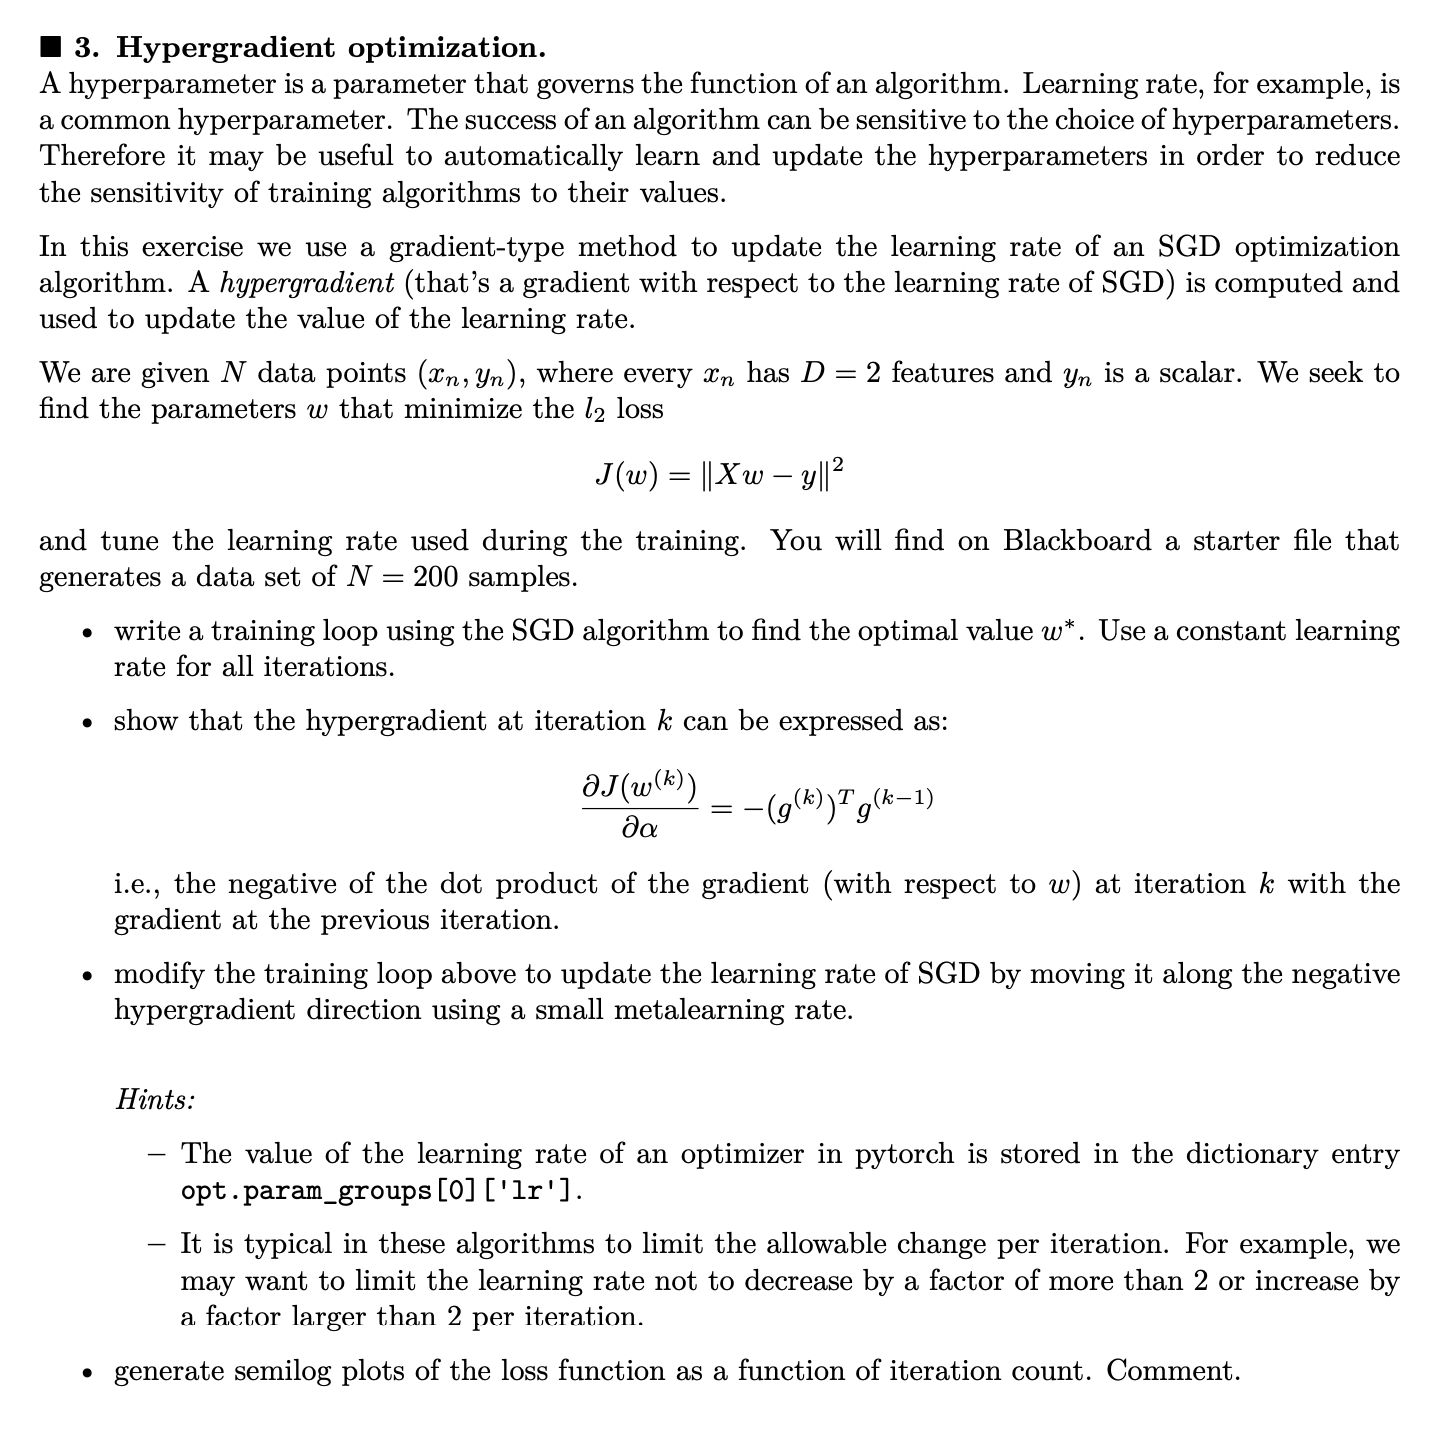

In [37]:
gen_cpu = torch.Generator()
gen_cpu.manual_seed(215)      # for repeatability

# generate  data
N, D = 200, 2
X = -5.0 + 10.0*torch.rand((N, D), generator=gen_cpu)
y = torch.matmul(X, torch.tensor([5.0, -3.0])) + 0.3 * torch.randn((N,), generator=gen_cpu)


max_iter = 20               # number of iterations
init_lr = 1e-2              # learning rate of SGD, starting value 
meta_lr = 1e-4              # learning rate of the learning rate
batch_size = 20
loss_vals= []               # record the loss values, for plotting at the end
lr_vals = []                # record the learning rate, for plotting

# Divide Data into Training and Testing
reg_dataset = IrisDataset(X, y)
train_dataset, test_dataset = divide_dataset(reg_dataset, test_prop=0.2) # 0.8 of training size rate
# Compute mean and std for each feature in the training set
mean = torch.mean(train_dataset.dataset.X, dim=0)
std = torch.std(train_dataset.dataset.X, dim=0)

# Normalize datasets
train_dataset.dataset.X = (train_dataset.dataset.X - mean) / std
test_dataset.dataset.X = (test_dataset.dataset.X - mean) / std

In [48]:
##########################################
###### Regression Model #########
##########################################
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

##########################################
##### Regression Training #######
##########################################
class RegressionTraining:
    def __init__(self, model:torch.nn.Module, train_dataset:Dataset, test_dataset:Dataset, criterion='manual'):
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.criterion = criterion if criterion == 'manual' else torch.nn.MSELoss()
        self.model = model

    def loss(self, pred_tensor, labels_tensor):
        if self.criterion == 'manual':
            loss = torch.mean(torch.linalg.norm((pred_tensor - labels_tensor), dim=1)**2)
        else:
            loss = self.criterion(pred_tensor, labels_tensor)
        return loss

    def test_model(self):
        # get the data
        test_data, labels = self.test_dataset[:]
        # predict 
        with torch.no_grad():
            pred_labels = self.model(test_data)
        test_loss = self.loss(pred_labels, labels)
        return test_loss.item()

    def compute_hypergradient(self, opt, metalearning_rate):
        # compute the hypergradient
        current_grad = self.model.linear.weight.grad
        grad_lr_tensor = - torch.sum(current_grad * self.prev_grad)
        current_lr = opt.param_groups[0]['lr']
        grad_lr_update = max(min(grad_lr_tensor.item(), 2*current_lr), -2*current_lr)
        opt.param_groups[0]['lr'] -= metalearning_rate * grad_lr_update

    def SGD(self, learning_rate=0.001, metalearning_rate=1e-5, batch_size=10, num_epochs=100):
        opt = torch.optim.SGD(self.model.parameters(), lr=learning_rate)
        data_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True) # randomize and get the batches

        self.train_loss = []
        self.test_loss = []
        self.lr_vals = []
        self.prev_grad = torch.zeros_like(self.model.linear.weight)
        for epoch in range(num_epochs):
            total_loss = 0
            
            for data_batch, label_batch in data_loader:

                # Reset gradients
                self.model.zero_grad()
            
                # Forward pass
                prob_predicted = self.model(data_batch)

                # calculate loss
                loss = self.loss(prob_predicted, label_batch) # compute the loss for the batch
                total_loss += loss.item()
        
                # Backward pass
                loss.backward()

                # update learning rate
                self.compute_hypergradient(opt, metalearning_rate)
                self.prev_grad = self.model.linear.weight.grad.clone()

                # step SGD opt
                opt.step()

            # test the model 
            loss_test_epoch = self.test_model()
            self.train_loss.append(total_loss / len(data_loader))
            self.test_loss.append(loss_test_epoch)
            self.lr_vals.append(opt.param_groups[0]['lr'])
            # print epoch
            print(f"Epoch: {epoch}, Training Loss Avg: {total_loss / len(data_loader):.4f}, Test Loss: {loss_test_epoch:.4f}, lr: {opt.param_groups[0]['lr']}")
    

In [49]:
# create the model
reg_model = RegressionModel(D) # dimension D

In [50]:
reg_trainer = RegressionTraining(reg_model, train_dataset, test_dataset, criterion='manual')
reg_trainer.SGD(num_epochs=max_iter, learning_rate=init_lr, metalearning_rate=meta_lr, batch_size=batch_size)

Epoch: 0, Training Loss Avg: 4843.1687, Test Loss: 8594.0293, lr: 0.010001998799760048
Epoch: 1, Training Loss Avg: 4846.9026, Test Loss: 8544.8926, lr: 0.010005998798639953
Epoch: 2, Training Loss Avg: 4796.5970, Test Loss: 8588.2793, lr: 0.01001400519831832
Epoch: 3, Training Loss Avg: 4791.4862, Test Loss: 8608.4355, lr: 0.010014003596077585
Epoch: 4, Training Loss Avg: 4788.6680, Test Loss: 8836.6865, lr: 0.01000999719399954
Epoch: 5, Training Loss Avg: 4805.4932, Test Loss: 8984.0947, lr: 0.010005992394802645
Epoch: 6, Training Loss Avg: 4847.3517, Test Loss: 9170.3213, lr: 0.010005990793843955
Epoch: 7, Training Loss Avg: 4825.5704, Test Loss: 8662.0049, lr: 0.010013997187117206
Epoch: 8, Training Loss Avg: 4836.7798, Test Loss: 8556.7119, lr: 0.010005987591927348
Epoch: 9, Training Loss Avg: 4851.2130, Test Loss: 8586.9111, lr: 0.010001984396891858
Epoch: 10, Training Loss Avg: 4828.3454, Test Loss: 8706.4561, lr: 0.009997982803454446
Epoch: 11, Training Loss Avg: 4830.5791, Tes

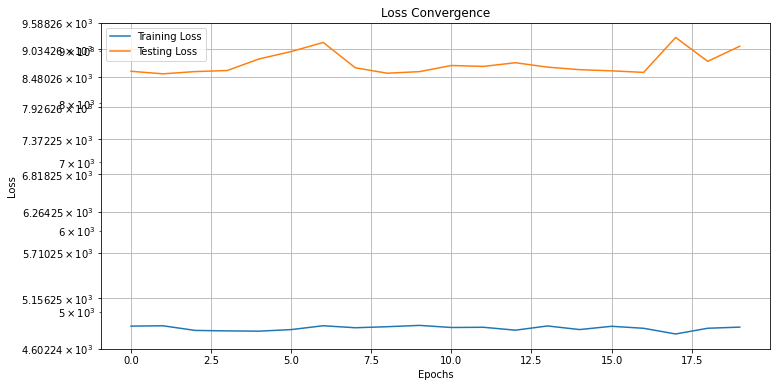

In [51]:
# Plot the semilog of the training and test loss
train_loss = reg_trainer.train_loss
test_loss = reg_trainer.test_loss
plot_loss(train_loss, test_loss)